# Entropic estimation of optimal transport maps

We experiment with the 

The idea ...

Setting : 2-samples estimates

*copié de la page 9*

The article proposes the following estimator of the map :
$$T_{\varepsilon,(n, n)}(x)=\frac{\frac{1}{n} \sum_{i=1}^n Y_i e^{\frac{1}{\varepsilon}\left(g_{\varepsilon,(n, n)}\left(Y_i\right)-\frac{1}{2}\left\|x-Y_i\right\|^2\right)}}{\frac{1}{n} \sum_{i=1}^n e^{\frac{1}{\varepsilon}\left(g_{\varepsilon,(n, n)}\left(Y_i\right)-\frac{1}{2}\left\|x-Y_i\right\|^2\right)}}$$
where $g_{\varepsilon,(n, n)}$ is the entropic potential corresponding to $Q_n$ in the optimal entropic plan between $P_n$ and $Q_n$, obtained by the ouput of Sinkhorn algo..

In [11]:
import sys

if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/ott-jax/ott@main

In [13]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.geometry.costs import SqPNorm
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn, sinkhorn_lr
from ott.tools import plot

In [14]:
def create_points(rng, n, T): # T must be a monotone scalar function !
    rngs = jax.random.split(rng, 2)

    x = jax.random.uniform(rngs[0], (n,2), minval = -1, maxval = 1)
    z = jax.random.uniform(rngs[1], (n,2), minval = -1, maxval = 1)

    y = T(z)
    
    return x, y

Create a {class}`~ott.problems.linear.linear_problem.LinearProblem` comparing two {class}`point clouds <ott.geometry.pointcloud.PointCloud>`.

In [105]:
rng = jax.random.PRNGKey(0)
T = lambda x : jnp.exp(x) #3 * x**2 * jnp.sign(x) # jnp.log(1.2 + x) #
n = 500
x,y = create_points(rng, n, T)
epsilon = 1e-1 /2

geom = pointcloud.PointCloud(x, y, cost_fn = SqPNorm(2) , epsilon = epsilon) # vérifier que ma cost_fn est la bonne !
ot_prob = linear_problem.LinearProblem(geom)

In [106]:
solver = sinkhorn.Sinkhorn()
ot_sink = solver(ot_prob)

In [107]:
ot_sink.ot_prob.geom.y.shape

(500, 2)

In [116]:
def entropic_map_estimator(ot_sink):
    g = ot_sink.g[:,None]
    Y = ot_sink.ot_prob.geom.y
    epsilon = ot_sink.ot_prob.geom.epsilon

    numerator = lambda x : jnp.mean(y * jnp.exp(1/epsilon * (g - 0.5 * jnp.linalg.norm(x - Y, ord=2, axis = 1, keepdims=True)**2)), axis = 0)
    denominator = lambda x : jnp.mean(  jnp.exp(1/epsilon * (g - 0.5 * jnp.linalg.norm(x - Y, ord=2, axis = 1, keepdims=True)**2)), axis = 0)


    T_hat = lambda x : numerator(x)/denominator(x)

    T_hat = jax.vmap(lambda x : numerator(x)/denominator(x))

    return T_hat

(500, 2)


[]

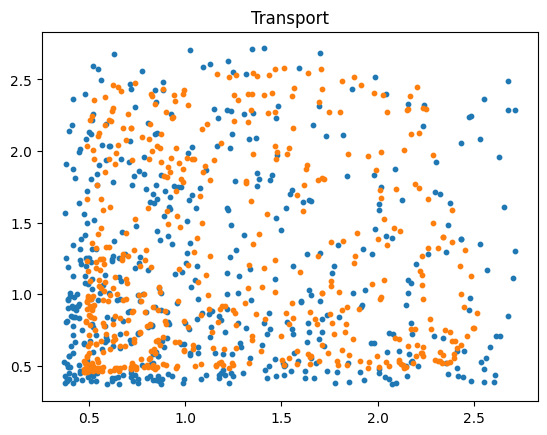

In [117]:
T_hat = entropic_map_estimator(ot_sink = ot_sink)

rng = jax.random.PRNGKey(1)
x_tilde, _ = create_points(rng, n, T)

y_tilde = T(x_tilde)
y_tilde_estimated = T_hat(x_tilde)

print(y_tilde_estimated.shape)

plt.figure()
plt.plot()
plt.scatter(y_tilde[:,0], y_tilde[:,1], s = 10)
plt.scatter(y_tilde_estimated[:,0], y_tilde_estimated[:,1], s = 10)
plt.title("Transport")
plt.plot()


In [130]:
from mpl_toolkits.mplot3d import Axes3D

tab = jnp.arange(-1,1,0.25)
X,Y = jnp.meshgrid(tab ,tab)

print(X.shape)
print(Y.shape)
print(jnp.concatenate((X[:,None],Y[:,None]), axis = 1))
Z,_ = T()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')


(8, 8)
(8, 8)
[[[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
  [-1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.  ]]

 [[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
  [-0.75 -0.75 -0.75 -0.75 -0.75 -0.75 -0.75 -0.75]]

 [[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
  [-0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5 ]]

 [[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
  [-0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25]]

 [[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
  [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]

 [[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
  [ 0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25]]

 [[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
  [ 0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5 ]]

 [[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
  [ 0.75  0.75  0.75  0.75  0.75  0.75  0.75  0.75]]]


TypeError: <lambda>() missing 1 required positional argument: 'x'

In [131]:
X

Array([[-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75],
       [-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75],
       [-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75],
       [-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75],
       [-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75],
       [-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75],
       [-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75],
       [-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75]],      dtype=float32)